# 10 Mapmatching of taxi GPS data

This example uses TransBigData+leuvenmapmatching to achieve the road network matching of taxi GPS data

## Preparing trajectory data

In [1]:
import transbigdata as tbd
import pandas as pd

#Read_data
data = pd.read_csv('data/TaxiData-Sample.csv',header = None)
data.columns = ['VehicleNum','Time','Lng','Lat','OpenStatus','Speed']

In [2]:
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching import visualization as mmviz

In [3]:
#obtain OD from trajectory data
oddata = tbd.taxigps_to_od(data,col = ['VehicleNum','Time','Lng','Lat','OpenStatus'])
#extract deliver and idle trip trajectories
data_deliver,data_idle = tbd.taxigps_traj_point(data,oddata,col=['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus'])

## Modeling road network

You can download the road network from openstreetmap.

In [4]:
# obtain road network
import osmnx as ox
bounds = [113.75, 22.4, 114.62, 22.86]
north, south, east, west = bounds[3], bounds[1], bounds[2], bounds[0]
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

In [5]:
#save road network
ox.save_graphml(G,'shenzhen.graphml')

If you alread have the road network data...

In [6]:
# Read the road network
import osmnx as ox
filepath = "shenzhen.graphml"
G = ox.load_graphml(filepath)

In [7]:
#Obtain the road GeoDataFrame and road centroid
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
edges['lon'] = edges.centroid.x
edges['lat'] = edges.centroid.y

/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_80320/1542180003.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['lon'] = edges.centroid.x
/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_80320/1542180003.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['lat'] = edges.centroid.y


In [8]:
#convert to projection coordinates
G_p = ox.project_graph(G, to_crs=2416)
nodes_p, edges_p = ox.graph_to_gdfs(G_p, nodes=True, edges=True)

<AxesSubplot:>

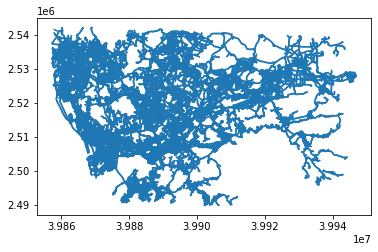

In [9]:
edges_p.plot()

In [11]:
# create road network
map_con = InMemMap(name='pNEUMA', use_latlon=False) # , use_rtree=True, index_edges=True)

for node_id, row in nodes_p.iterrows():
    map_con.add_node(node_id, (row['y'], row['x']))
for node_id_1, node_id_2, _ in G_p.edges:
    map_con.add_edge(node_id_1, node_id_2)

## Mapmatching

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Searching closeby nodes with linear search, use an index and set max_dist
/opt/anaconda3/lib/python3.8/site-packages/leuvenmapmatching/visualization.py:194: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(px, py, 'o-', linewidth=linewidth, markersize=linewidth * 2, alpha=0.75,


(<Figure size 1440x846.228 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

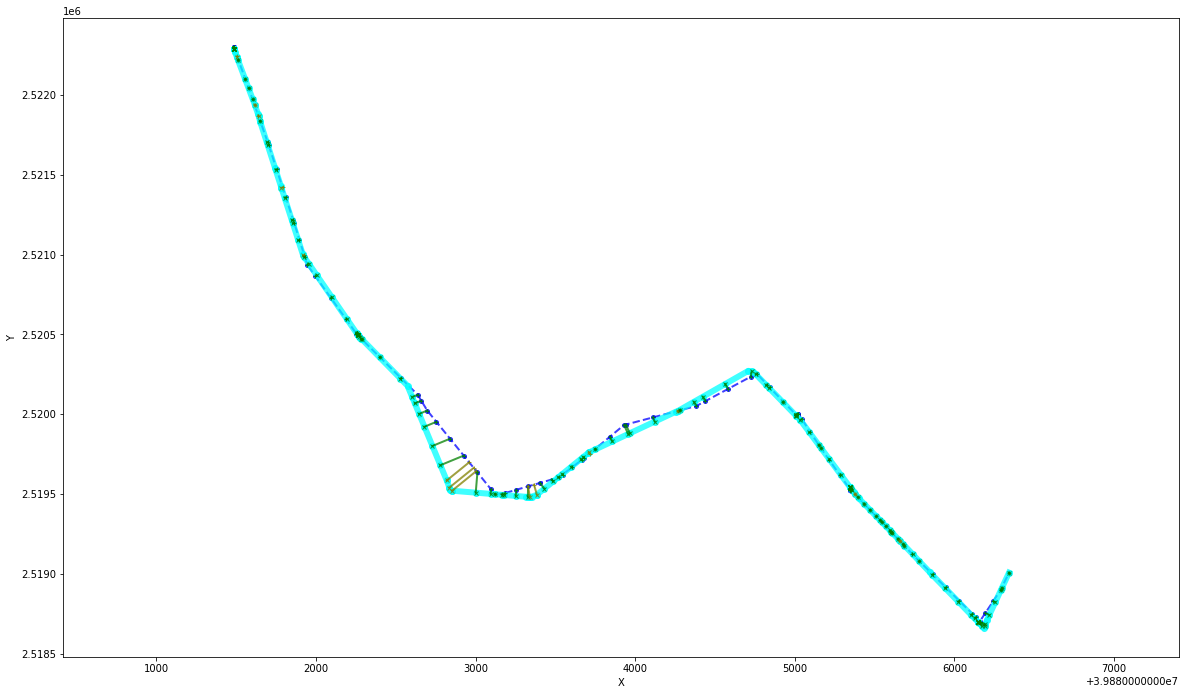

In [12]:
# Extract one of the trajectory using transbigdata
import geopandas as gpd
tmp_gdf = data_deliver[data_deliver['ID'] == 27].sort_values(by='Time')
# trajectory densify
tmp_gdf = tbd.traj_densify(
    tmp_gdf, col=['ID', 'Time', 'Lng', 'Lat'], timegap=15)
# convert coordinate
tmp_gdf['geometry'] = gpd.points_from_xy(tmp_gdf['Lng'], tmp_gdf['Lat'])
tmp_gdf = gpd.GeoDataFrame(tmp_gdf)
tmp_gdf.crs = {'init': 'epsg:4326'}
tmp_gdf = tmp_gdf.to_crs(2416)
# obtain trajectoies
path = list(zip(tmp_gdf.geometry.y, tmp_gdf.geometry.x))
# create mapmatcher
matcher = DistanceMatcher(map_con,
                          max_dist=500,
                          max_dist_init=170,
                          min_prob_norm=0.0001,
                          non_emitting_length_factor=0.95,
                          obs_noise=50,
                          obs_noise_ne=50,
                          dist_noise=50,
                          max_lattice_width=20,
                          non_emitting_states=True)
# mapmatching
states, _ = matcher.match(path, unique=False)
# plot the result
mmviz.plot_map(map_con, matcher=matcher,
               show_labels=False, show_matching=True,  # show_graph=True,
               filename=None)


/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


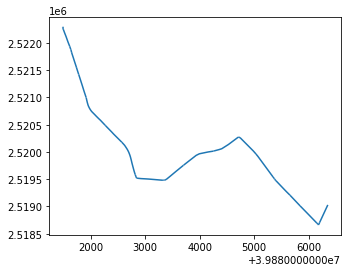

In [14]:
#Obtain the path GeoDataFrame
pathdf = pd.DataFrame(matcher.path_pred_onlynodes,columns = ['u'])
pathdf['v'] = pathdf['u'].shift(-1)
pathdf = pathdf[-pathdf['v'].isnull()]
pathgdf = pd.merge(pathdf,edges_p.reset_index())
pathgdf = gpd.GeoDataFrame(pathgdf)
pathgdf.plot()
pathgdf.crs = {'init':'epsg:2416'}
pathgdf_4326 = pathgdf.to_crs(4326)

## Visualization

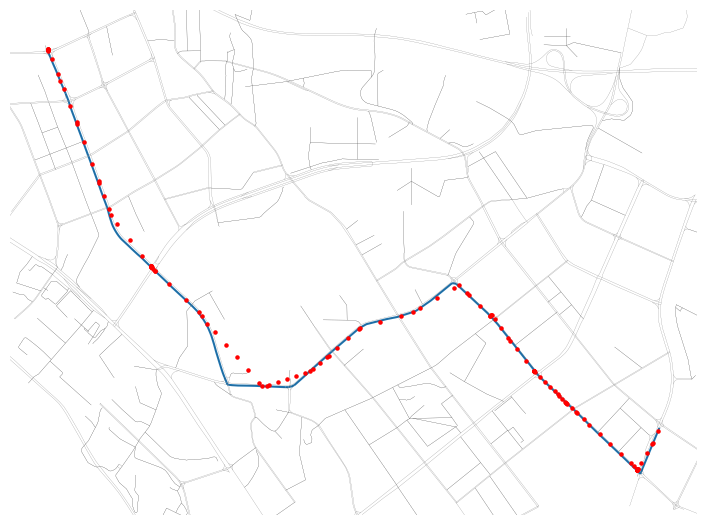

In [15]:
#Visualize with road network
import matplotlib.pyplot as plt

fig     = plt.figure(1,(8,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))
#visualization bounds
bounds = pathgdf_4326.unary_union.bounds
gap = 0.003
bounds = [bounds[0]-gap,bounds[1]-gap,bounds[2]+gap,bounds[3]+gap]
#plot the matched path
pathgdf_4326.plot(ax = ax,zorder = 1)
#plot the road network geometry
tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)
#plot the trajectory points
tmp_gdf.to_crs(4326).plot(ax = ax,color = 'r',markersize = 5,zorder = 2)

plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()